# Distance Feature Significance Exploration - Anushka

#### Reading in the data

In [124]:
import pandas as pd

data = pd.read_parquet("../data/curated/final_train_hospital_cbd_dist_data")
data.head()

,url,price,address,property_type,latitude,longitude,Beds,Baths,Parking,bond,extracted_price,suburb,property_id,nearest_station_id,train_station_distance_km,cbd_distance_km,nearest_hospital_id,nearest_hospital_distance
0,https://www.domain.com.au/10-allara-court-donv...,"$1,400.00","10 Allara Court, Donvale VIC 3111",Townhouse,-37.774273,145.181126,4.0,3.0,2.0,9125.0,1400.0,Donvale,0,19900,5.6596,25.93487,H5063,1.920280
1,https://www.domain.com.au/10-51-55-leslie-stre...,$500 Per Week,"10/51-55 Leslie Street, Donvale VIC 3111",Apartment / Unit / Flat,-37.781431,145.181474,2.0,1.0,1.0,2173.0,500.0,Donvale,7,19900,4.6923,24.88939,H5063,1.272015
2,https://www.domain.com.au/293-richardson-stree...,$630.00,"293 Richardson Street, Carlton North VIC 3054",House,-37.784081,144.965615,2.0,1.0,0.0,2738.0,630.0,Carlton North,19,19969,1.4377,4.14098,H0372,1.651170
3,https://www.domain.com.au/786-drummond-street-...,$720.00,"786 Drummond Street, Carlton North VIC 3054",House,-37.786146,144.971258,3.0,1.0,0.0,3129.0,720.0,Carlton North,22,19969,2.2956,4.03091,H0381,1.577533
4,https://www.domain.com.au/8-1068-lygon-street-...,$750 pw,"8/1068 Lygon Street, Carlton North VIC 3054",Apartment / Unit / Flat,-37.780942,144.970534,3.0,2.0,2.0,3260.0,750.0,Carlton North,26,19969,1.7662,4.22506,H0372,1.990258


#### Calculating outliers for weekly rent prices

In [125]:
import pandas as pd
df = data.copy()

Q1 = df['extracted_price'].quantile(0.25)
Q3 = df['extracted_price'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")



Q1 (25th percentile): 500.0
Q3 (75th percentile): 725.0
IQR: 225.0
Lower Bound for Outliers: 162.5
Upper Bound for Outliers: 1062.5


#### Filtering out outliers

In [126]:

filtered_df = df[(df['extracted_price'] >= lower_bound) & (df['extracted_price'] <= upper_bound)]

print(f"Original DataFrame size: {df.shape}")
print(f"Filtered DataFrame size: {filtered_df.shape}")


Original DataFrame size: (9828, 18)
Filtered DataFrame size: (8909, 18)


24/09/30 11:35:40 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 503055 ms exceeds timeout 120000 ms
24/09/30 11:35:40 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/30 11:35:45 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

#### Dropping any null values before correlation analysis

In [123]:
import pandas as pd

# Assuming 'df' is your pandas DataFrame
initial_row_count = len(filtered_df)
print(f"Initial number of rows: {initial_row_count}")

Initial number of rows: 8909


In [116]:

# Assuming 'df' is your pandas DataFrame
# Drop rows where any of the specified columns have null values
df_cleaned = filtered_df.dropna(subset=['nearest_hospital_distance', 'extracted_price', 'cbd_distance_km', 'train_station_distance_km'])

# Count rows after dropping nulls
final_row_count = len(df_cleaned)
print(f"Number of rows after dropping nulls: {final_row_count}")


Number of rows after dropping nulls: 8907


In [117]:
rows_dropped = initial_row_count - final_row_count
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 2


#### Boxplots to show effect of dropping outliers

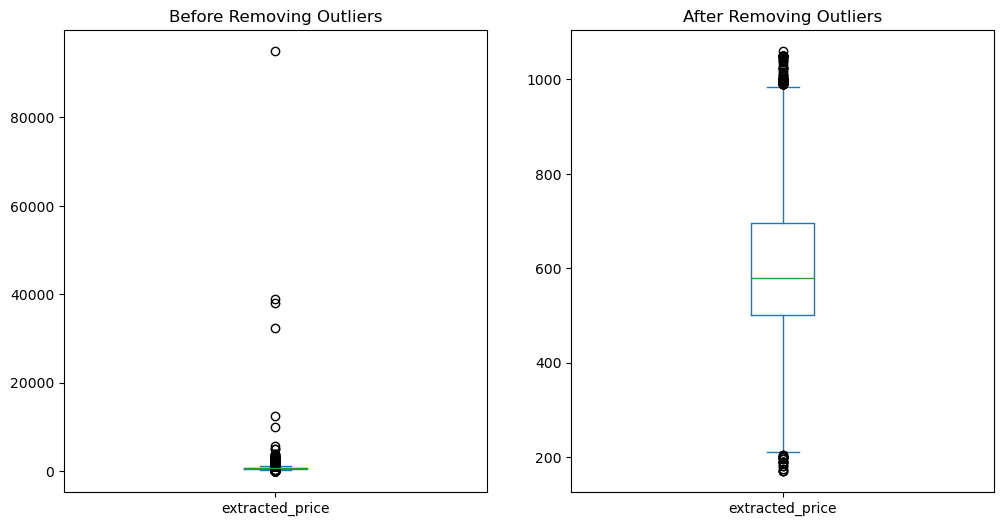

In [118]:
import matplotlib.pyplot as plt

# Plot before and after removing outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df['extracted_price'].plot(kind='box', ax=ax[0], title='Before Removing Outliers')
filtered_df['extracted_price'].plot(kind='box', ax=ax[1], title='After Removing Outliers')

plt.show()


#### Correlation analysis

#### Pearson correlation is low for all distance features, potentially implying that relationship is not linear (evident from graphs). However, the p-values show that these features are statistically significant (more so that the result is unlikely to have arisen by chance alone).

In [119]:
from scipy import stats
import numpy as np


# Assuming `df` is your DataFrame and you have numeric columns for prices and distances
r, p_value = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['cbd_distance_km'])
print("Correlation Coefficient for CBD Distance:", r)
print("P-value for CBD Distance:", p_value)

r_hospital, p_value_hospital = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['nearest_hospital_distance'])
print("Correlation Coefficient for Hospital Distance:", r_hospital)
print("P-value for Hospital Distance:", p_value_hospital)

r_train, p_value_train = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['train_station_distance_km'])
print("Correlation Coefficient for Nearest Train Station Distance:", r_train)
print("P-value for Nearest Train Station Distance:", p_value_train)


Correlation Coefficient for CBD Distance: -0.17501607836029634
P-value for CBD Distance: 3.3580277671978465e-62
Correlation Coefficient for Hospital Distance: -0.13675630651431567
P-value for Hospital Distance: 1.9126865233590944e-38
Correlation Coefficient for Nearest Train Station Distance: -0.08329581547156369
P-value for Nearest Train Station Distance: 3.440749785644156e-15


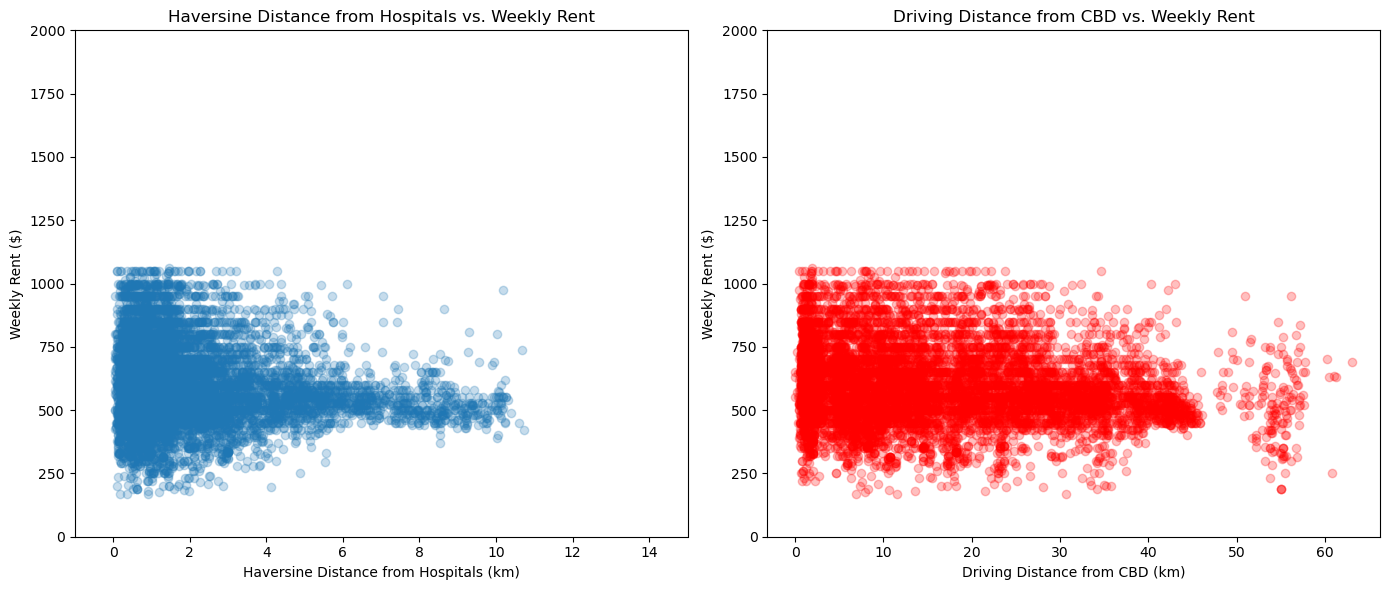

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
max_rent = filtered_df['extracted_price'].max()
# Scatter plot for Haversine Distance from Hospitals vs. Weekly Rent
ax[0].scatter(filtered_df['nearest_hospital_distance'],filtered_df['extracted_price'], alpha=0.25)
ax[0].set_title('Haversine Distance from Hospitals vs. Weekly Rent')
ax[0].set_xlabel('Haversine Distance from Hospitals (km)')
ax[0].set_ylabel('Weekly Rent ($)')
ax[0].set_ylim(0,2000)
ax[0].set_xlim(-1,15) 

# Scatter plot for Driving Distance from CBD vs. Weekly Rent
ax[1].scatter(filtered_df['cbd_distance_km'], filtered_df['extracted_price'], alpha=0.25, color='r')
ax[1].set_title('Driving Distance from CBD vs. Weekly Rent')
ax[1].set_xlabel('Driving Distance from CBD (km)')
ax[1].set_ylabel('Weekly Rent ($)')
ax[1].set_ylim(0, 2000) 
plt.tight_layout()
plt.show()


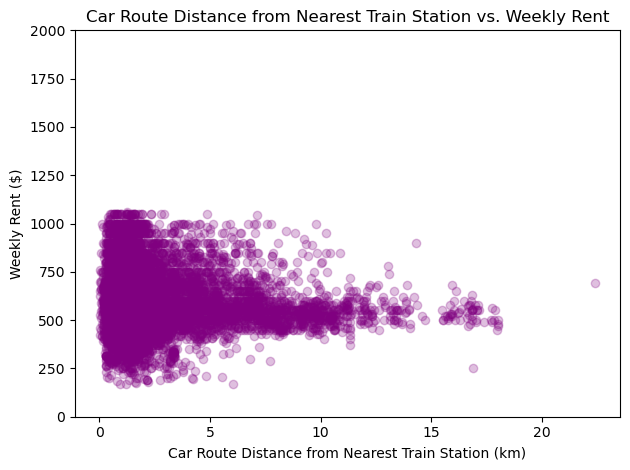

In [121]:
import matplotlib.pyplot as plt

# Create a new figure and axis object
fig, ax = plt.subplots()

# Scatter plot for Car Route Distance from Nearest Train Station vs. Weekly Rent
ax.scatter(filtered_df['train_station_distance_km'], filtered_df['extracted_price'], alpha=0.25, color='purple')  # Using blue color here
ax.set_title('Car Route Distance from Nearest Train Station vs. Weekly Rent')
ax.set_xlabel('Car Route Distance from Nearest Train Station (km)')
ax.set_ylabel('Weekly Rent ($)')

# Set y-axis limit to show rents up to $2000 for better visualization
ax.set_ylim(0, 2000)

# Adjust layout to prevent overlap and make everything fit nicely
plt.tight_layout()

# Display the plot
plt.show()
